# Sistemas de Recomendación
### Carga de Datos de Movie Lens

In [67]:
import pandas as pd
import numpy as np

In [68]:
df = pd.read_csv("../datasets/ml-100k/u.data.csv", sep="\t", header=None)

In [69]:
type(df)

pandas.core.frame.DataFrame

In [70]:
df.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [71]:
df.shape

(100000, 4)

In [72]:
df.columns

Int64Index([0, 1, 2, 3], dtype='int64')

In [73]:
df.columns= ["UserID", "ItemID", "Rating", "TimeStamp"]

In [74]:
df.head()

,UserID,ItemID,Rating,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [75]:
len(df.groupby("UserID"))

943

## Análisis Exploratorio de los Items

In [76]:
import matplotlib.pyplot as plt

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

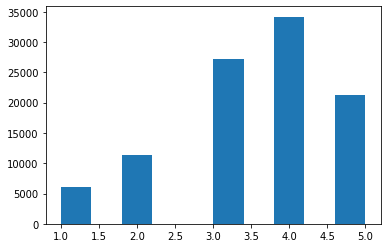

In [77]:
plt.hist(df["Rating"])

In [78]:
df.groupby("Rating")["UserID"].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

(array([1.146e+03, 2.490e+02, 1.390e+02, 6.700e+01, 3.800e+01, 2.400e+01,
        7.000e+00, 5.000e+00, 6.000e+00, 1.000e+00]),
 array([  1. ,  59.2, 117.4, 175.6, 233.8, 292. , 350.2, 408.4, 466.6,
        524.8, 583. ]),
 <a list of 10 Patch objects>)

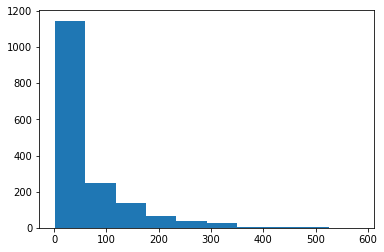

In [79]:
pelis = df.groupby("ItemID")["ItemID"].count()
plt.hist(pelis)

### Representación en Forma Matricial

In [80]:
n_users = df["UserID"].unique().shape[0]
n_users

943

In [81]:
n_items = df["ItemID"].unique().shape[0]
n_items

1682

In [82]:
ratings = np.zeros((n_users, n_items))
ratings.shape

(943, 1682)

In [83]:
for row in df.itertuples():
    ratings[row[1] - 1, row[2] - 1] = row[3]

In [84]:
type(ratings)

numpy.ndarray

In [85]:
ratings.shape

(943, 1682)

In [86]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [87]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0]*ratings.shape[1])
sparsity *= 100
print("El coeficiente de Esparseidad es %0.2f" %sparsity)

El coeficiente de Esparseidad es 6.30


### Crear Conjuntos de entrenamiento y validación

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
ratings_train, ratings_test = train_test_split(ratings, test_size=0.3, random_state = 42)

In [90]:
ratings_train.shape

(660, 1682)

In [91]:
ratings_test.shape

(283, 1682)

## Filtro Colaborativo basado en Usuarios
* Matriz de similaridad entre usuarios (distancia del coseno) 
* Predecir la valoración desconocida de un ítem "i" para un usuario activo "u", basados en la suma ponderada de todas las valoraciones del resto de usuario para dicho ítem
* Recomendamos los nuevos ítems a los usuarios según lo establecido en los pasos anteriores

In [92]:
import numpy as np
import sklearn

La distancia del coseno entrega valores de 0 a 1, siendo 0 el mismo valor. La similaridad es al revés, es 1 cuando es igual. Por eso hay que hacer una corrección restando 1 - el valor

In [93]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_train)

In [94]:
sim_matrix.shape

(660, 660)

In [95]:
sim_matrix

array([[1.        , 0.17448349, 0.18009754, ..., 0.13331459, 0.17695593,
        0.21882481],
       [0.17448349, 1.        , 0.07993097, ..., 0.07175808, 0.09552622,
        0.05512655],
       [0.18009754, 0.07993097, 1.        , ..., 0.0191736 , 0.02233385,
        0.10310785],
       ...,
       [0.13331459, 0.07175808, 0.0191736 , ..., 1.        , 0.04853428,
        0.05142508],
       [0.17695593, 0.09552622, 0.02233385, ..., 0.04853428, 1.        ,
        0.1198022 ],
       [0.21882481, 0.05512655, 0.10310785, ..., 0.05142508, 0.1198022 ,
        1.        ]])

In [96]:
users_prediction = sim_matrix.dot(ratings_train) / np.array([np.abs(sim_matrix).sum(axis=1)]).T

In [97]:
users_prediction

array([[2.10259747e+00, 5.86975978e-01, 3.40264192e-01, ...,
        0.00000000e+00, 7.33611460e-03, 6.04379414e-03],
       [1.40999723e+00, 2.91863934e-01, 2.68085289e-01, ...,
        0.00000000e+00, 3.50378592e-03, 2.32963985e-03],
       [1.69014833e+00, 3.13648440e-01, 3.26127887e-01, ...,
        0.00000000e+00, 3.25391767e-03, 1.77210119e-03],
       ...,
       [1.73393747e+00, 4.06719333e-01, 3.21166908e-01, ...,
        0.00000000e+00, 2.71269625e-03, 9.00511411e-03],
       [2.34361031e+00, 8.10544770e-01, 4.73941025e-01, ...,
        0.00000000e+00, 1.01130066e-02, 9.66427605e-03],
       [2.36796969e+00, 5.98146138e-01, 3.85569804e-01, ...,
        0.00000000e+00, 6.39996638e-03, 5.37442746e-03]])

In [98]:
from sklearn.metrics import mean_squared_error

In [160]:
def get_mse(preds, actuals):
    if(preds.shape[0] == actuals.shape[1]):
        actuals=actuals.T        
    
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()  #flatten convierte a Vector
    return mean_squared_error(preds,actuals)

In [100]:
get_mse(users_prediction, ratings_train)

7.878218313143215

## Filtro Colaborativo basado en KNN para Usuarios

In [101]:
from sklearn.neighbors import NearestNeighbors

In [102]:
k = 5

In [103]:
neighbors = NearestNeighbors(k, "cosine")

In [104]:
neighbors.fit(ratings_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius='cosine')

In [105]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance=True)

In [106]:
top_k_distances.shape

(660, 5)

In [107]:
top_k_distances[0]

array([ 0.        , 41.71330723, 43.3474336 , 45.04442252, 45.04442252])

In [108]:
top_k_users.shape

(660, 5)

In [109]:
top_k_users[0]

array([  0, 211,  16, 583, 428], dtype=int64)

In [110]:
users_predict_k = np.zeros(ratings_train.shape)

for i in range(ratings_test.shape[0]):  # Para cada usuario en el conjunto de entrenamiento
    users_predict_k [i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i])/np.array([np.abs(top_k_distances[i].T.sum(axis=0))]).T
    
    

In [111]:
users_predict_k.shape

(660, 1682)

In [112]:
get_mse(users_predict_k, ratings_train)

11.123111657936281

## Filtro Colaborativo Basado en Ítems

In [113]:
n_movies = ratings_train.shape[1]
n_movies

1682

In [114]:
neighbors = NearestNeighbors(n_movies, "cosine")

In [115]:
neighbors.fit(ratings_train.T) #Se transpone para que queden las películas en filas

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=1682, p=2,
                 radius='cosine')

In [116]:
top_k_distances_items, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [117]:
top_k_distances_items.shape

(1682, 1682)

In [118]:
top_k_items.shape

(1682, 1682)

In [119]:
top_k_items

array([[   0,  120,  404, ...,  285,  312,  301],
       [   1,  575,  232, ...,  257,   99,   49],
       [   2,  742, 1094, ...,  180,   99,   49],
       ...,
       [1565, 1571, 1570, ...,  180,   99,   49],
       [1680, 1671, 1582, ...,  180,   99,   49],
       [1681, 1596, 1592, ...,  180,   99,   49]], dtype=int64)

In [120]:
item_prediction = ratings_train.dot(top_k_distances_items) / np.array([np.abs(top_k_distances_items).sum(axis=1)])

#### Esta sería la valoración que se le da a un usuario, basado en la similaridad entre las películas

In [121]:
item_prediction.shape

(660, 1682)

In [122]:
get_mse(item_prediction, ratings_train)

11.172565375125632

### Filtrado Colaborativo basado en KNN por Ítems

In [147]:
k = 20
neighbors = NearestNeighbors(k,"cosine")
neighbors.fit(ratings_train.T)
top_k_distances_items, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [148]:
top_k_distances_items.shape

(1682, 20)

In [149]:
top_k_items.shape

(1682, 20)

In [150]:
top_k_items[0]

array([  0, 120, 404, 116, 221, 150, 117, 180,   6, 741,  27,  94, 256,
       236, 124,  81,  24, 587, 227, 110], dtype=int64)

In [152]:
preds_items = np.zeros(ratings_train.T.shape)

for i in range(ratings_train.T.shape[0]): # Para cada uno de las columnas (ítems)
    if(i%50 == 0):
        print("Iteración", i)
    div=1
    
    if np.abs(top_k_distances_items[i]).sum(axis=0) > 0:
        den = np.array(np.abs(top_k_distances_items[i].sum(axis=0)))
    preds_items[i, :] = top_k_distances_items[i].dot(ratings_train.T[top_k_items][i]) / np.array(den).T

Iteración 0
Iteración 50
Iteración 100
Iteración 150
Iteración 200
Iteración 250
Iteración 300
Iteración 350
Iteración 400
Iteración 450
Iteración 500
Iteración 550
Iteración 600
Iteración 650
Iteración 700
Iteración 750
Iteración 800
Iteración 850
Iteración 900
Iteración 950
Iteración 1000
Iteración 1050
Iteración 1100
Iteración 1150
Iteración 1200
Iteración 1250
Iteración 1300
Iteración 1350
Iteración 1400
Iteración 1450
Iteración 1500
Iteración 1550
Iteración 1600
Iteración 1650


In [161]:
get_mse(preds_items, ratings_train)

8.377192404568891